In [15]:
import pandas as pd, numpy as np, warnings, statsmodels.api as sm, re
import matplotlib.pyplot as plt, matplotlib, seaborn as sns
warnings.filterwarnings(action = 'ignore')
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'AppleGothic')

from sklearn.linear_model import *
from sklearn.model_selection import *

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [27]:
## 데이터 로드

data = pd.read_csv('Interest_rate_prediction.csv')
df = data.copy()

df

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2009-01-01,0.25,0.00,0.50,-4.5,7.8,88.108,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2008-12
1,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-02
3,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,2.658,1379.5,2.0,1.50,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-03
4,2009-05-01,0.25,0.00,0.25,-0.7,9.4,88.387,3.174,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.180,1331.5,3.5,4.50,National Summary Overall Economic Activity Eco...,0.056,0.797,0.147,0.9991,2024-02
183,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.106,4.329,1349.4,3.5,4.50,National Summary Overall Economic Activity Ove...,0.068,0.807,0.126,0.9974,2024-03
184,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.096,4.595,1382.0,3.5,4.50,National Summary Overall Economic Activity Nat...,0.076,0.783,0.141,0.9982,2024-04
185,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.096,4.514,1384.5,3.5,4.50,National Summary Overall Economic Activity Nat...,0.076,0.783,0.141,0.9982,2024-05


In [28]:
## 추가 전처리: BB_text 텍스트 데이터 전 처리 및 sentiment 재계산

# BB_text 텍스트 데이터 전 처리
# 소문자 통일, 공백 제거
df['BB_text'] = df['BB_text'].str.lower()  # 소문자로
df['BB_text'] = df['BB_text'].str.strip()  # 앞뒤 공백 제거
df['BB_text'] = df['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
df['BB_text'] = df['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# 불용어 제거
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])
df['BB_text'] = df['BB_text'].apply(remove_stopwords)


# sentiment 재계산
# 감성분석
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df[['BB_neg', 'BB_neu', 'BB_pos', 'BB_sentiment']] = df['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

In [29]:
# target: 상한 기준금리
df['TARGET'] = df['DFEDTARU']
del df['DFEDTARL'],df['DFEDTARU'], df['BB_text'], df['BB_neg'], df['BB_neu'], df['BB_pos'], df['DATE_YM']
df['DATE'] = pd.to_datetime(df['DATE'])

df.set_index('DATE', inplace=True)
df

,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_sentiment,TARGET
DATE,,,,,,,,,,
2009-01-01,0.50,-4.5,7.8,88.108,2.244,1259.5,3.0,2.50,0.9672,0.25
2009-02-01,0.25,-4.5,8.3,88.266,2.844,1379.5,2.5,2.00,0.9672,0.25
2009-03-01,0.25,-4.5,8.7,88.169,3.041,1534.0,2.0,2.00,-0.0337,0.25
2009-04-01,0.25,-0.7,9.0,88.295,2.658,1379.5,2.0,1.50,-0.8687,0.25
2009-05-01,0.25,-0.7,9.4,88.387,3.174,1282.0,2.0,1.25,-0.8687,0.25
...,...,...,...,...,...,...,...,...,...,...
2024-03-01,5.50,1.4,3.8,122.782,4.180,1331.5,3.5,4.50,0.9977,5.50
2024-04-01,5.50,2.8,3.9,123.106,4.329,1349.4,3.5,4.50,0.9952,5.50
2024-05-01,5.50,2.8,4.0,123.096,4.595,1382.0,3.5,4.50,0.9974,5.50


In [23]:
## 기술 통계
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2009-01-01 to 2024-07-01
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IR_FORCAST    187 non-null    float64
 1   GDPGR         187 non-null    float64
 2   UNRATE        187 non-null    float64
 3   PCEPI         187 non-null    float64
 4   TNX           187 non-null    float64
 5   USD           187 non-null    float64
 6   KR_IR         187 non-null    float64
 7   ECB_IR        187 non-null    float64
 8   BB_sentiment  187 non-null    float64
 9   TARGET        187 non-null    float64
dtypes: float64(10)
memory usage: 16.1 KB


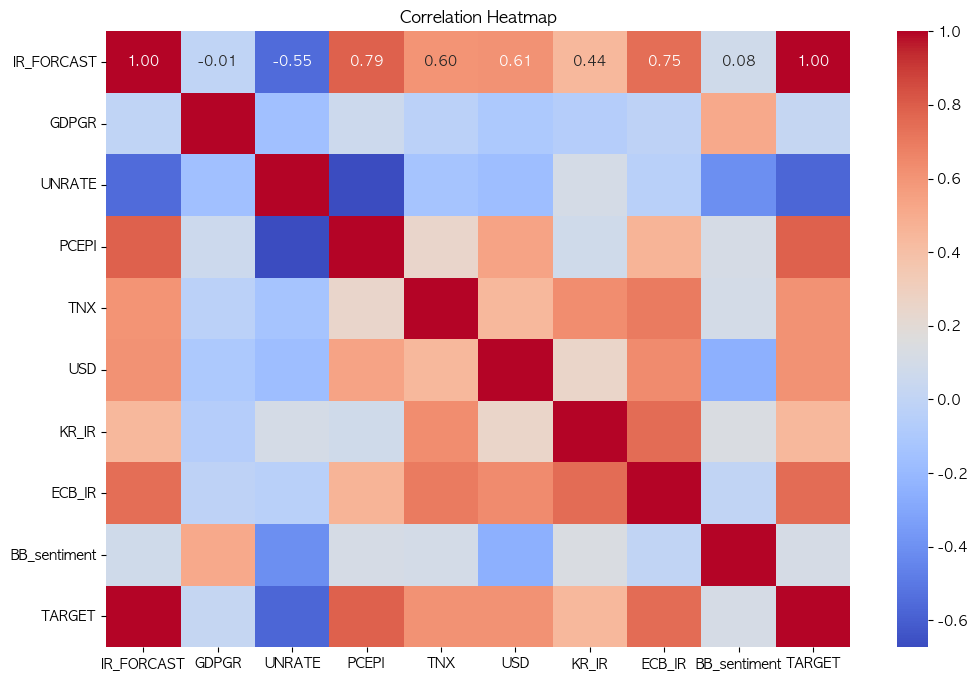

In [30]:
## 변수들간의 상관관계 및 독립변수와 종속변수(target)과의 상관관계 확인

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# IR_FORECAST제외, PCEPI, ECR_IR, TNX, USD 양의 상관관계 / UNRATE, GDPGR 음의 상관관계

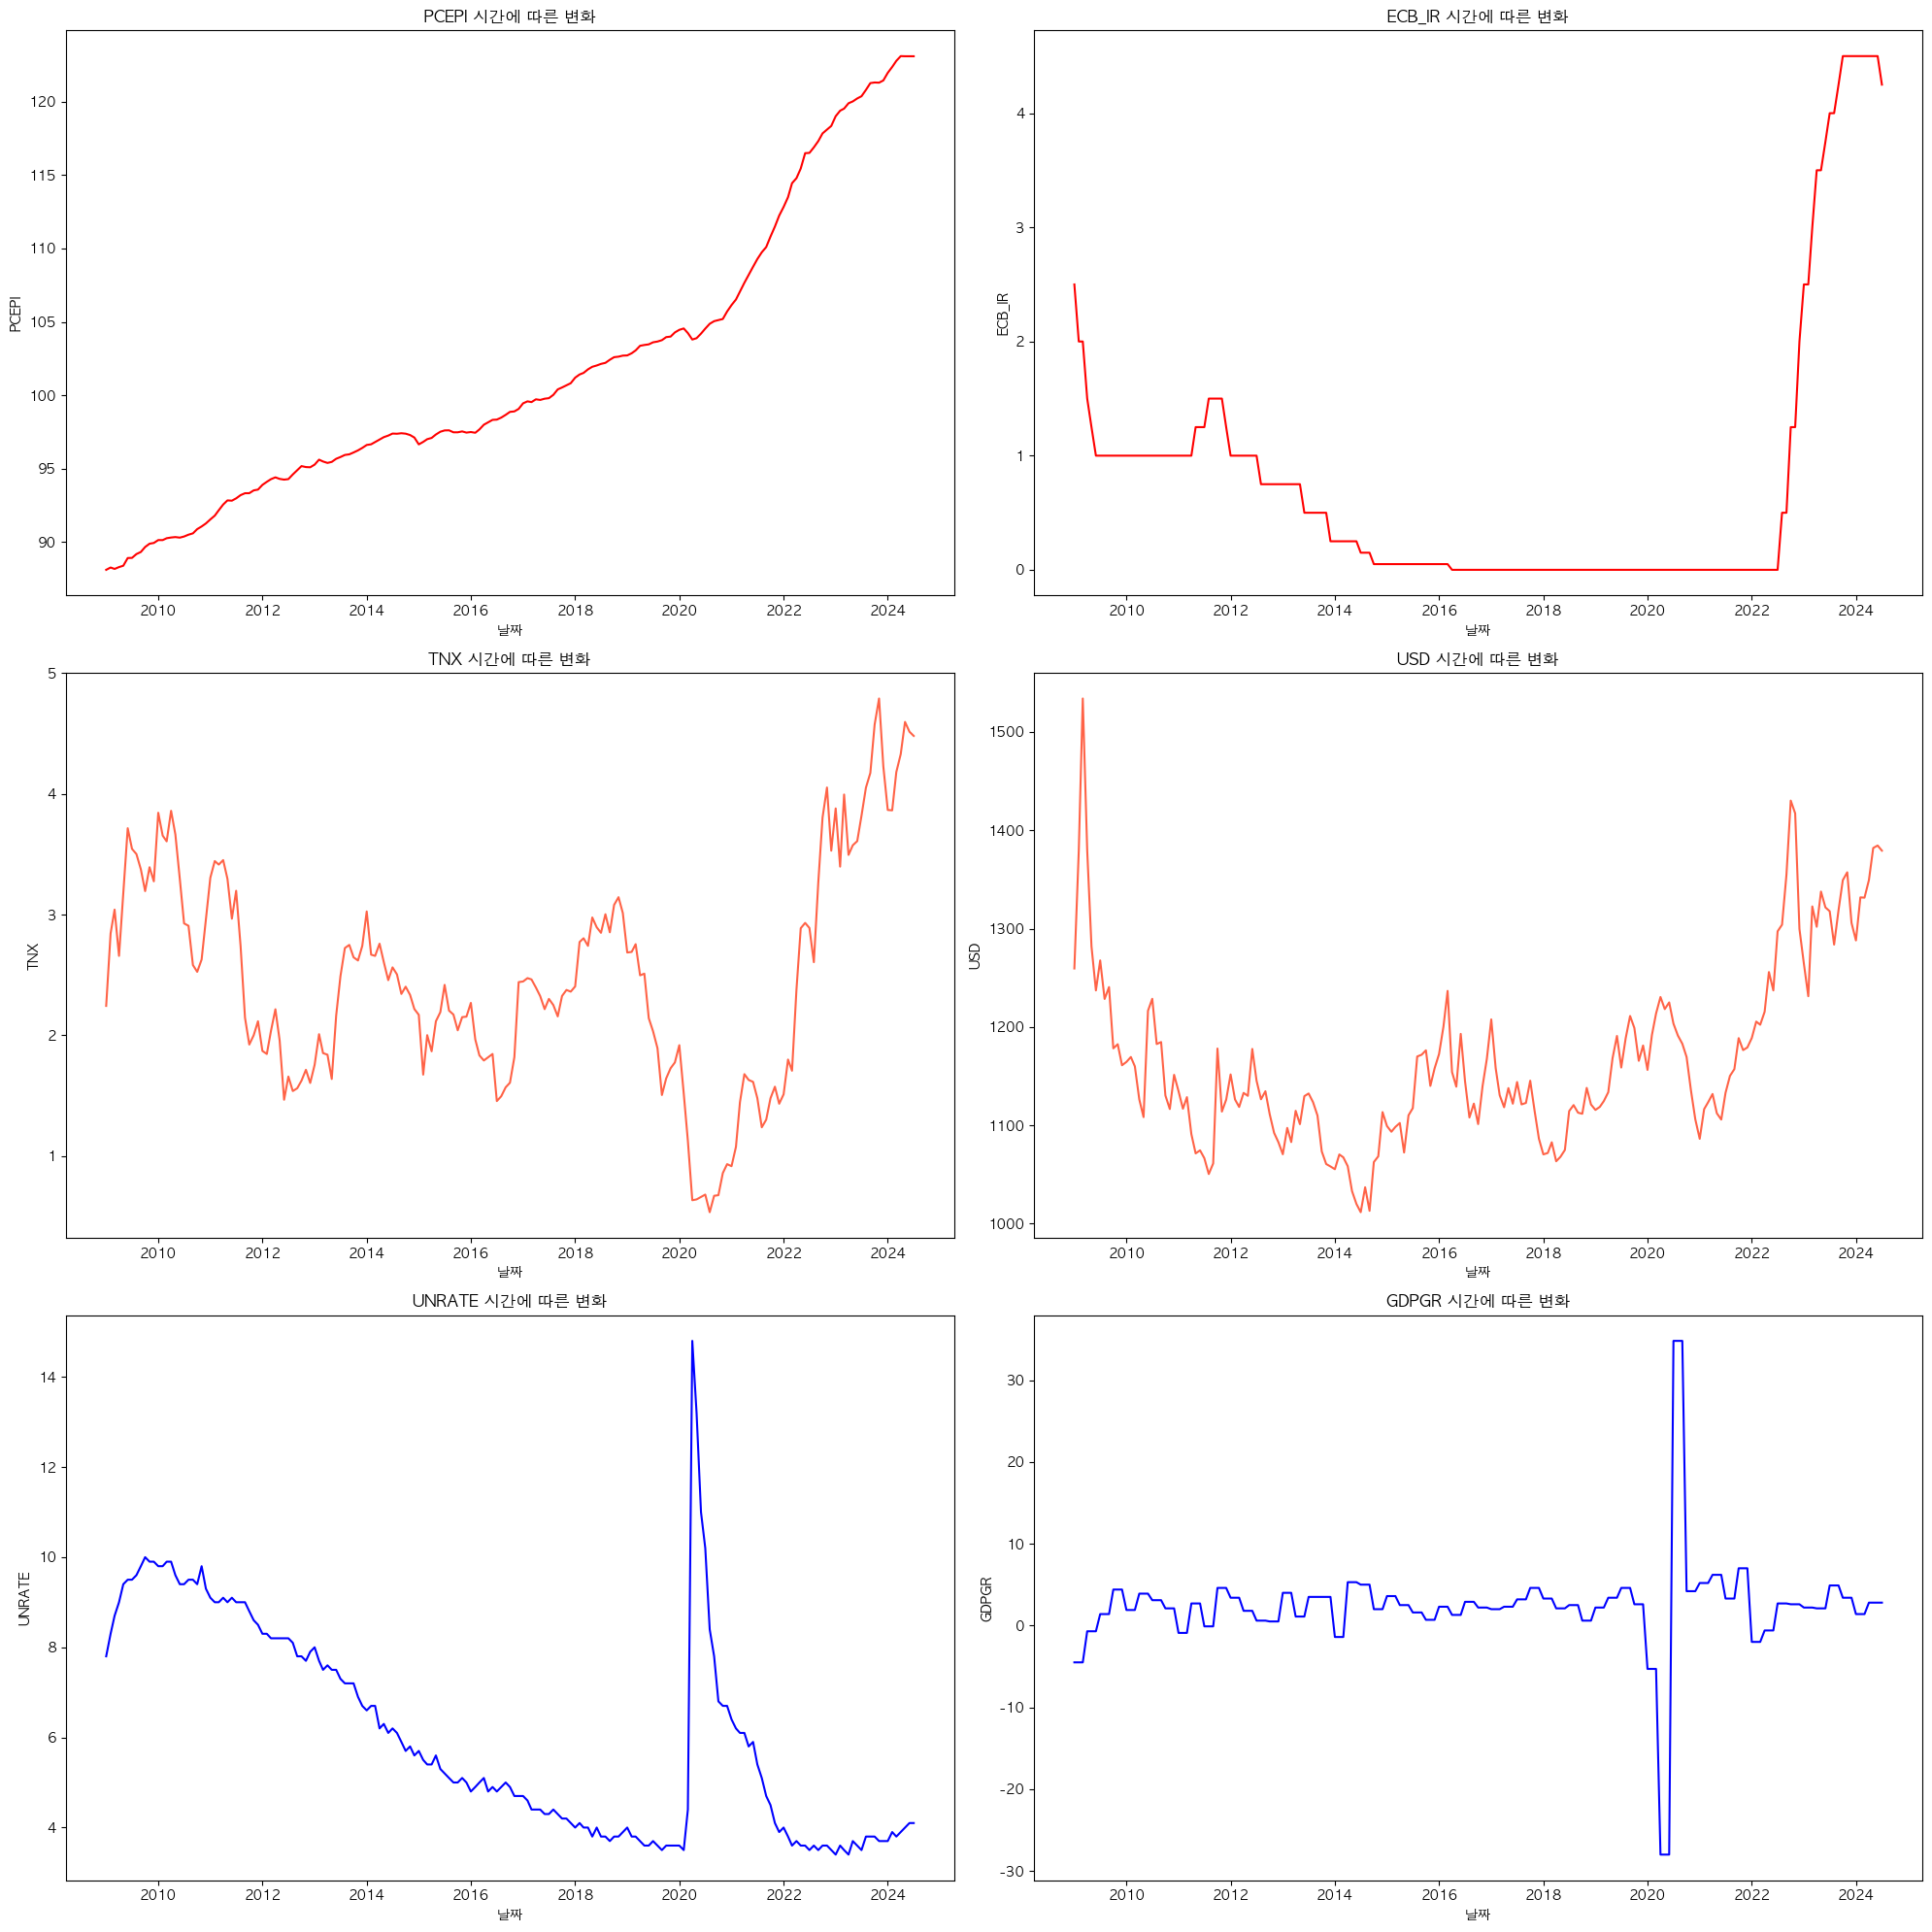

In [25]:
## 상관계수 높은 독립변수들 시각화
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
plt.plot(df.index, df['PCEPI'], label='PCEPI', color='red')
plt.title('PCEPI 시간에 따른 변화')
plt.xlabel('날짜')
plt.ylabel('PCEPI')

plt.subplot(3, 2, 2)
plt.plot(df.index, df['ECB_IR'], label='ECB_IR', color='red')
plt.title('ECB_IR 시간에 따른 변화')
plt.xlabel('날짜')
plt.ylabel('ECB_IR')

plt.subplot(3, 2, 3)
plt.plot(df.index, df['TNX'], label='TNX', color='tomato')
plt.title('TNX 시간에 따른 변화')
plt.xlabel('날짜')
plt.ylabel('TNX')

plt.subplot(3, 2, 4)
plt.plot(df.index, df['USD'], label='USD', color='tomato')
plt.title('USD 시간에 따른 변화')
plt.xlabel('날짜')
plt.ylabel('USD')

plt.subplot(3, 2, 5)
plt.plot(df.index, df['UNRATE'], label='UNRATE', color='blue')
plt.title('UNRATE 시간에 따른 변화')
plt.xlabel('날짜')
plt.ylabel('UNRATE')

plt.subplot(3, 2, 6)
plt.plot(df.index, df['GDPGR'], label='GDPGR', color='blue')
plt.title('GDPGR 시간에 따른 변화')
plt.xlabel('날짜')
plt.ylabel('GDPGR')

plt.tight_layout()
plt.show()

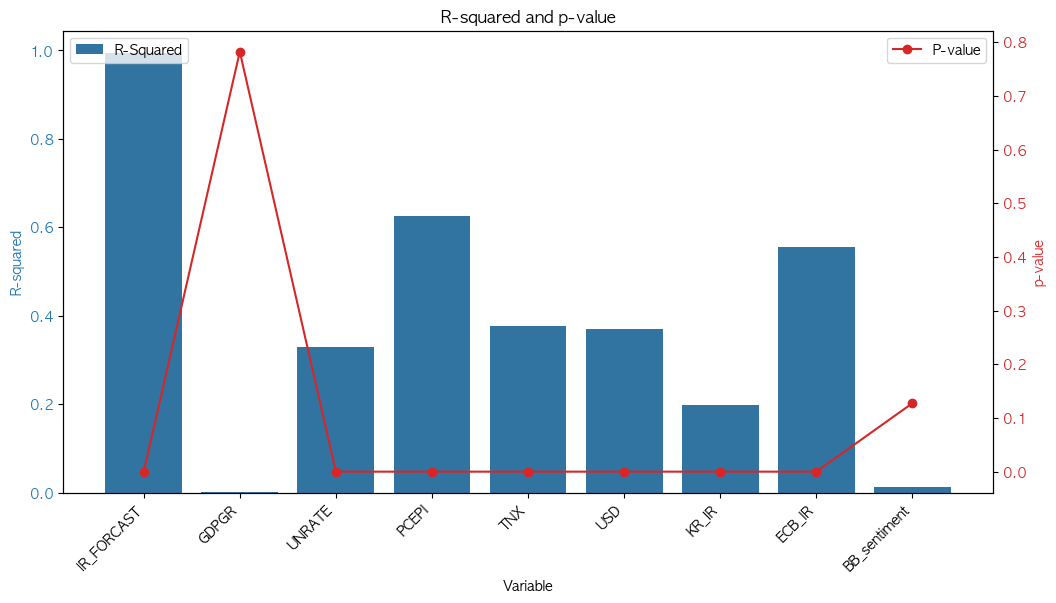

In [26]:
## 간단한 회귀 분석

# 독립 변수와 종속 변수 정의
target,predictors = df['TARGET'], df.drop(columns='TARGET')

# 회귀 분석 및 결과 저장
results = {}
for column in predictors.columns:
    X = sm.add_constant(predictors[[column]])  # 상수항 추가
    model = sm.OLS(target, X).fit()
    results[column] = {
        'R-squared': model.rsquared,
        'p-value': model.pvalues[1]  # 변수의 p-value
    }

# 데이터프레임으로 변환
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.columns = ['Variable', 'R-squared', 'p-value']

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# R-squared 막대 그래프
color = 'tab:blue'
ax1.set_xlabel('Variable')
ax1.set_ylabel('R-squared', color=color)
sns.barplot(x='Variable', y='R-squared', data=results_df, ax=ax1, color=color, label='R-Squared')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# p-value 선 그래프
ax2 = ax1.twinx()  # 동일한 x축을 공유하는 두 번째 y축
color = 'tab:red'
ax2.set_ylabel('p-value', color=color)
ax2.plot(results_df['Variable'], results_df['p-value'], marker='o', color=color, label='P-value')
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 제목 추가
plt.title('R-squared and p-value')
plt.show()